## Detector model: 3-level system

In [2]:
from sympy import *
#from sympy.physics.matrices import mdft
from sympy.physics.quantum import TensorProduct
from sympy.functions.special.delta_functions import Heaviside
from sympy.physics.quantum.dagger import Dagger

from sympy.stats import ContinuousRV, variance, std

from sympy.plotting import plot, plot3d_parametric_line

import numpy as np

import scipy.integrate

import matplotlib
import matplotlib.pyplot as plt

# matplotlib.rcParams['text.usetex'] = False

# https://matplotlib.org/gallery/mplot3d/lines3d.html?highlight=parametric
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

In [3]:
from IPython.display import display, Latex #, Math

In [4]:
init_printing ()

In [5]:
gamma = Symbol('gamma', real=True, positive=True)
t = Symbol('t', real=True)
tprime = Symbol('t\'', real=True)
omega = Symbol('omega', real=True)
nu = Symbol('nu', real=True)

In [6]:
H = Matrix ([
    [0, 1, 0],
    [1, 0, 1],
    [0, 1, 0]
])

In [7]:
H.eigenvects()

⎡⎛      ⎡⎡-1⎤⎤⎞  ⎛        ⎡⎡ 1 ⎤⎤⎞  ⎛       ⎡⎡1 ⎤⎤⎞⎤
⎢⎜      ⎢⎢  ⎥⎥⎟  ⎜        ⎢⎢   ⎥⎥⎟  ⎜       ⎢⎢  ⎥⎥⎟⎥
⎢⎜0, 1, ⎢⎢0 ⎥⎥⎟, ⎜-√2, 1, ⎢⎢-√2⎥⎥⎟, ⎜√2, 1, ⎢⎢√2⎥⎥⎟⎥
⎢⎜      ⎢⎢  ⎥⎥⎟  ⎜        ⎢⎢   ⎥⎥⎟  ⎜       ⎢⎢  ⎥⎥⎟⎥
⎣⎝      ⎣⎣1 ⎦⎦⎠  ⎝        ⎣⎣ 1 ⎦⎦⎠  ⎝       ⎣⎣1 ⎦⎦⎠⎦

In [8]:
U_t = exp(-I*H*t)

In [9]:
psi_0 = Matrix([1, (1+I)/sqrt(2), 0])/sqrt(2)
psi_0

⎡ √2  ⎤
⎢ ──  ⎥
⎢ 2   ⎥
⎢     ⎥
⎢1   ⅈ⎥
⎢─ + ─⎥
⎢2   2⎥
⎢     ⎥
⎣  0  ⎦

In [10]:
unitary_psi_t = U_t @ psi_0

In [11]:
unitary_psi_t

⎡                                          ⎛ √2⋅ⅈ⋅t        -√2⋅ⅈ⋅t⎞⎤
⎢                                          ⎜ℯ         1   ℯ       ⎟⎥
⎢        ⎛      √2⋅ⅈ⋅t       -√2⋅ⅈ⋅t⎞   √2⋅⎜─────── + ─ + ────────⎟⎥
⎢⎛1   ⅈ⎞ ⎜  √2⋅ℯ         √2⋅ℯ       ⎟      ⎝   4      2      4    ⎠⎥
⎢⎜─ + ─⎟⋅⎜- ────────── + ───────────⎟ + ───────────────────────────⎥
⎢⎝2   2⎠ ⎝      4             4     ⎠                2             ⎥
⎢                                                                  ⎥
⎢     ⎛      √2⋅ⅈ⋅t       -√2⋅ⅈ⋅t⎞                                 ⎥
⎢     ⎜  √2⋅ℯ         √2⋅ℯ       ⎟                                 ⎥
⎢  √2⋅⎜- ────────── + ───────────⎟           ⎛ √2⋅ⅈ⋅t    -√2⋅ⅈ⋅t⎞  ⎥
⎢     ⎝      4             4     ⎠   ⎛1   ⅈ⎞ ⎜ℯ         ℯ       ⎟  ⎥
⎢  ─────────────────────────────── + ⎜─ + ─⎟⋅⎜─────── + ────────⎟  ⎥
⎢                 2                  ⎝2   2⎠ ⎝   2         2    ⎠  ⎥
⎢                                                                  ⎥
⎢                                 

In [12]:
prob_t = Matrix([0, 0, 0])
for i in 0, 1, 2:
    prob_t[i] = abs(unitary_psi_t[i])**2

In [13]:
prob_t

⎡   2⋅√2⋅ⅈ⋅t      2⋅√2⋅ⅈ⋅t    √2⋅ⅈ⋅t      √2⋅ⅈ⋅t         -√2⋅ⅈ⋅t      -√2⋅ⅈ⋅t 
⎢  ℯ           ⅈ⋅ℯ           ℯ         ⅈ⋅ℯ         5    ℯ          ⅈ⋅ℯ        
⎢- ───────── - ─────────── + ─────── - ───────── + ── + ──────── + ────────── 
⎢      32           16          8          8       16      8           8      
⎢                                                                             
⎢                         2⋅√2⋅ⅈ⋅t      2⋅√2⋅ⅈ⋅t        -2⋅√2⋅ⅈ⋅t      -2⋅√2⋅ⅈ
⎢                        ℯ           ⅈ⋅ℯ           3   ℯ            ⅈ⋅ℯ       
⎢                        ───────── + ─────────── + ─ + ────────── - ──────────
⎢                            16           8        8       16            8    
⎢                                                                             
⎢   2⋅√2⋅ⅈ⋅t      2⋅√2⋅ⅈ⋅t    √2⋅ⅈ⋅t      √2⋅ⅈ⋅t         -√2⋅ⅈ⋅t      -√2⋅ⅈ⋅t 
⎢  ℯ           ⅈ⋅ℯ           ℯ         ⅈ⋅ℯ         5    ℯ          ⅈ⋅ℯ        
⎢- ───────── - ─────────── - ─────── + ───────── + ─

In [14]:
simplify(
    prob_t[0] + prob_t[1] + prob_t[2]
)

In [15]:
unitary_psi_n = lambdify(t, unitary_psi_t, 'numpy')
_prob_n = lambdify(t, prob_t, 'numpy')
def prob_n(_t):
    return np.real(_prob_n(_t))

In [16]:
def phase_color(_z):
    return np.imag(_z)

<!--
#### Complex argument color code
* <span style="color: #fe0">__Yellow__</span> (or generally the "highest"): imaginary, positive
* <span style="color: #086">__Green__ </span> (or generally the "midrange"): real
* <span style="color: #408">__Purple__</span> (or generally the "lowest"): imaginary, negative
-->

In [17]:
TMIN, TMAX = 0, 3*pi/sqrt(2) # one and a half periods, for graphical purposes...
TMIN_N, TMAX_N = float(TMIN), float(TMAX)

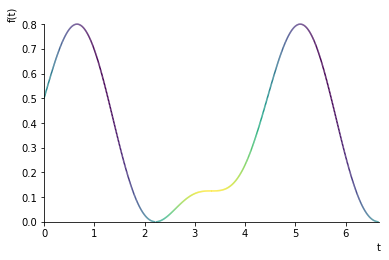

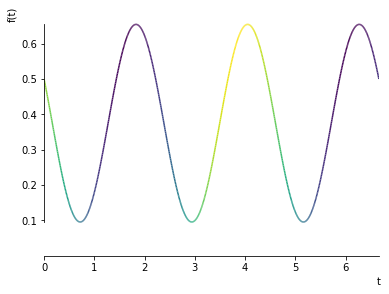

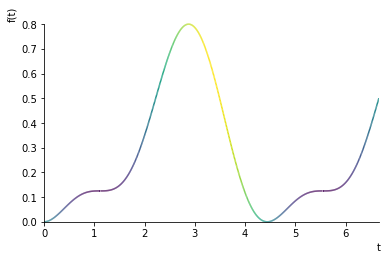

In [18]:
for i in 0, 1, 2:
    pl = plot(
        prob_t[i],
        (t, TMIN, TMAX),
        adaptive=False, nb_of_points=1000, show=False)
    # Need the numeric version to customize color function
    pl[0].line_color = lambda _t: phase_color( unitary_psi_n(_t)[i] )
    pl.axis_center = (0, 0)
    pl.show()

In [19]:
NPLOTPOINTS = 1000

In [20]:
times = np.linspace(TMIN_N, TMAX_N, num=NPLOTPOINTS)
times_extended = np.linspace(TMIN_N, 40*TMAX_N, num=NPLOTPOINTS)

In [21]:
probs = np.zeros((3, NPLOTPOINTS))

In [22]:
probs

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
for i in 0, 1, 2:
    probs[i] = prob_n(times)[i]

In [24]:
UNISYM = {
    'psi': u'\u03C8',
    '^2' : u'\u00B2'
}
PROB_LABELS     = ['', '', '']
PROB_AMP_LABELS = ['', '', '']
                
for i in 0, 1, 2:
    PROB_AMP_LABELS[i] = '<' + str(i) + '|' + UNISYM['psi'] + '>'
    PROB_LABELS[i]     = '|' + PROB_AMP_LABELS[i] + '|' + UNISYM['^2']

https://matplotlib.org/gallery/lines_bars_and_markers/stackplot_demo.html#sphx-glr-gallery-lines-bars-and-markers-stackplot-demo-py

In [25]:
prob_stack = np.vstack(probs)

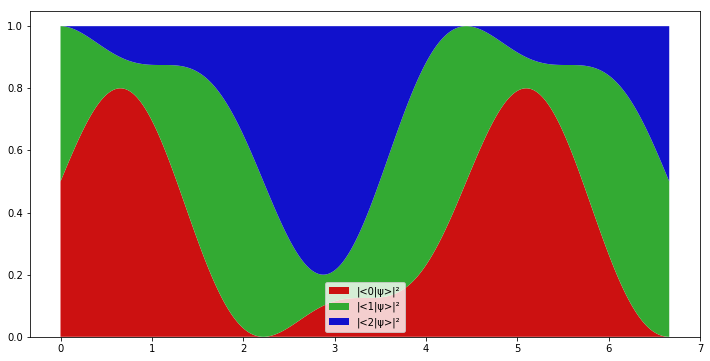

In [26]:
labels = PROB_LABELS
colors = ["#cc1111", "#33aa33", "#1111cc"]

fig, ax = plt.subplots(figsize=(12, 6))
ax.stackplot(times, probs[0], probs[1], probs[2], labels=labels, colors=colors)
ax.legend(loc='lower center')
plt.show()

In [27]:
rgbs = []
for i in range(NPLOTPOINTS):
    rgbs.append(
        (
            probs[0][i],
            probs[1][i],
            probs[2][i]
        )
    )

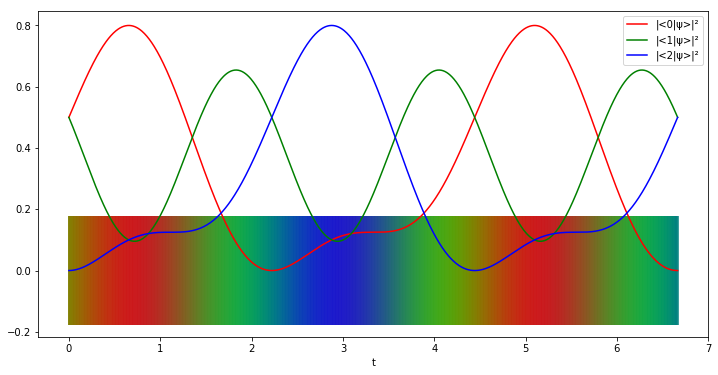

In [28]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlabel('t')
ax.scatter(times, np.zeros(NPLOTPOINTS),
            c=rgbs, marker='|', s=12000)

# "virtual", don't really want to show, only for legend
_c = ['r', 'g', 'b']
for i in 0, 1, 2:
    ax.plot(
        times, probs[i],
        c=_c[i],
        #linewidth=1,
    )
    
ax.legend(
    PROB_LABELS,
    loc='upper right'
)

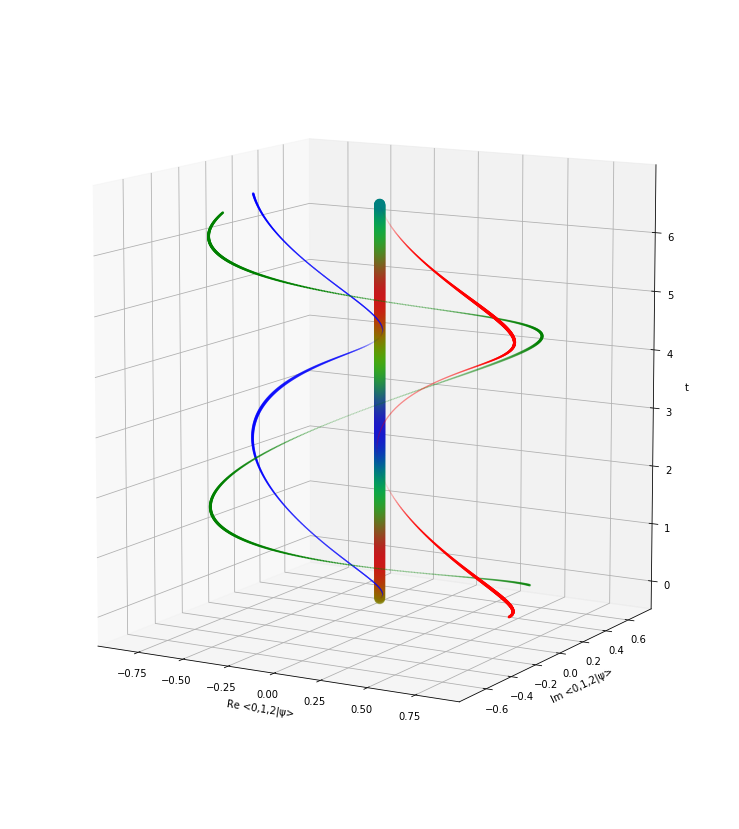

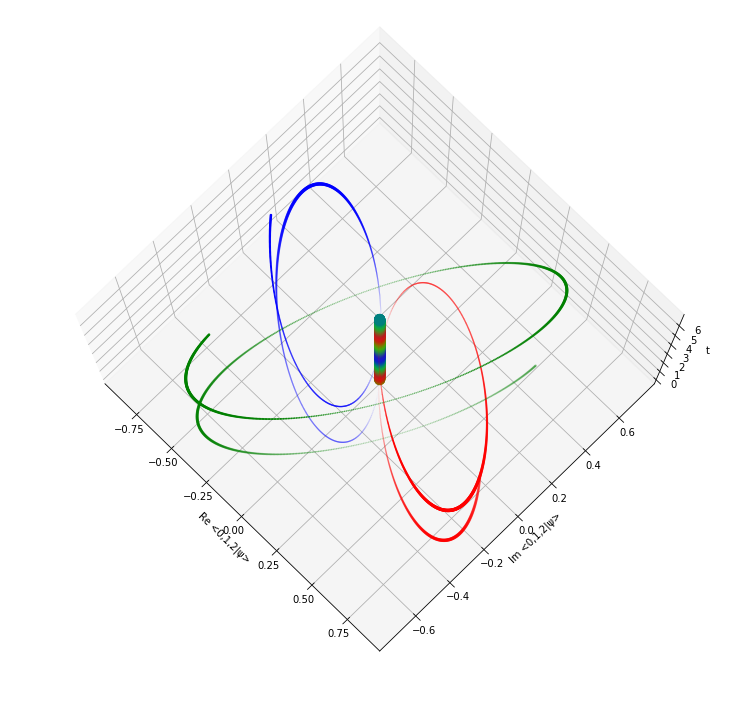

In [29]:
# 3D parametric plot
for (vertical_angle, horizontal_angle, height, width) in (10, -60, 15, 13), (80, -45, 13, 13):
    fig = plt.figure(figsize=(width, height))


    ax = fig.gca(projection='3d')

    ax.view_init(vertical_angle, horizontal_angle) # rotate 3d point of view

    ax.set_xlabel('Re <0,1,2|\u03C8>')
    ax.set_ylabel('Im <0,1,2|\u03C8>')
    ax.set_zlabel('t')

    ax.scatter(
        np.zeros(NPLOTPOINTS, dtype=np.float),
        np.zeros(NPLOTPOINTS, dtype=np.float),
        times,

        c = rgbs,
        s = 100
    )
    for i in 0, 1, 2:
        ax.scatter(
            np.real(unitary_psi_n(times)[i][0]),
            np.imag(unitary_psi_n(times)[i][0]),
            times,

            marker = '.',
            #depthshade=False,
            s = (probs[i]**2)*40,
            c = _c[i]
        )

## Complex potential (detection by absorption)

Need to switch everything to numeric.

In [30]:
from scipy.linalg import expm, norm

In [31]:
H_n = np.array(H).astype(np.complex)

In [32]:
H_n

array([[0.+0.j, 1.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j]])

In [33]:
GAMMA = 0.02
psi_0_n = np.array(psi_0.T).astype(np.complex)[0]

In [34]:
psi_0_n

array([0.70710678+0.j , 0.5       +0.5j, 0.        +0.j ])

In [35]:
def D(_gamma=GAMMA):
    # no 1/2 factor, absorbed in the _gamma in the matrix here
    return np.array([
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, _gamma]
    ], dtype=np.complex)

In [36]:
D()

array([[0.  +0.j, 0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.02+0.j]])

In [37]:
def K(_gamma=GAMMA):
    return H_n - 1j*D(_gamma)

In [38]:
K()

array([[0.+0.j  , 1.+0.j  , 0.+0.j  ],
       [1.+0.j  , 0.+0.j  , 1.+0.j  ],
       [0.+0.j  , 1.+0.j  , 0.-0.02j]])

In [39]:
def B(_t, _gamma=GAMMA):
    return expm(-1j*K(_gamma)*_t)

In [40]:
B(0)

array([[1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j]])

In [41]:
def non_unitary_psi(_t, _gamma=GAMMA):
    return B(_t, _gamma) @ psi_0_n

In [42]:
evolution = np.zeros((3, NPLOTPOINTS), dtype=np.complex)
evolution_extended = np.zeros((3, NPLOTPOINTS), dtype=np.complex)

for i in 0, 1, 2:
    _iter = (non_unitary_psi(_t)[i] for _t in times)
    _iter_extended = (non_unitary_psi(_t)[i] for _t in times_extended)

    evolution[i] = np.fromiter(_iter, np.complex)
    evolution_extended[i] = np.fromiter(_iter_extended, np.complex)

_iter_norm = (norm(non_unitary_psi(_t)) for _t in times)
norms = np.fromiter(_iter_norm, np.float)

_iter_norm_extended = (norm(non_unitary_psi(_t)) for _t in times_extended)
norms_extended = np.fromiter(_iter_norm_extended, np.float)

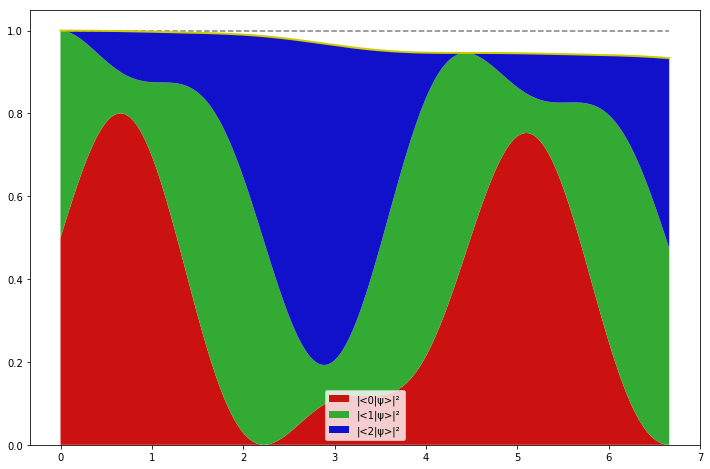

In [43]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(times, np.ones(NPLOTPOINTS), c='grey', linestyle='dashed')

ax.plot(times, norms**2, c='#cccc00', linewidth=2)

ax.stackplot(
    times,
    np.abs(evolution[0])**2,
    np.abs(evolution[1])**2,
    np.abs(evolution[2])**2,
    
    labels=labels, colors=colors
)

ax.legend(loc='lower center')

plt.show()

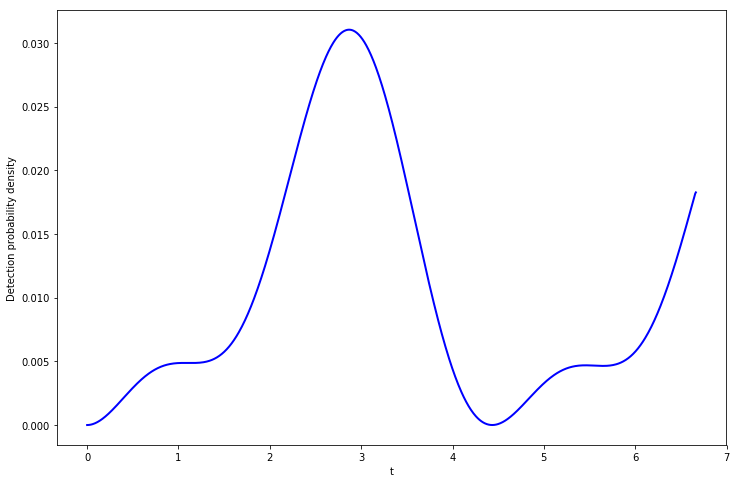

In [44]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlabel('t')
ax.set_ylabel('Detection probability density')
ax.plot(times, -np.gradient(norms**2, times), c='b', linewidth=2)

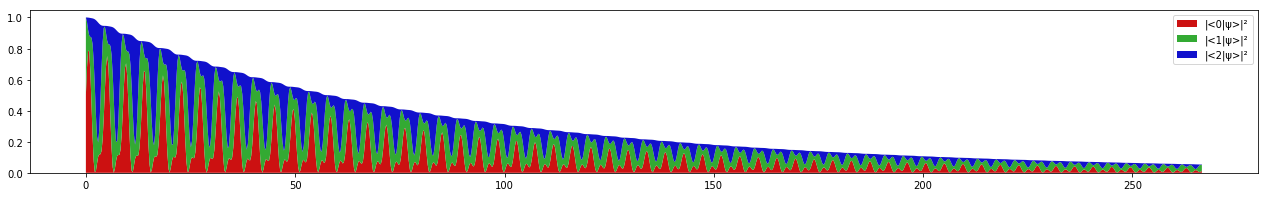

In [45]:
labels = PROB_LABELS
colors = ["#cc1111", "#33aa33", "#1111cc"]

fig, ax = plt.subplots(figsize=(22, 3))

ax.stackplot(
    times_extended,
    np.abs(evolution_extended[0])**2,
    np.abs(evolution_extended[1])**2,
    np.abs(evolution_extended[2])**2,
    
    labels=labels, colors=colors
)

ax.legend(loc='upper right')

plt.show()

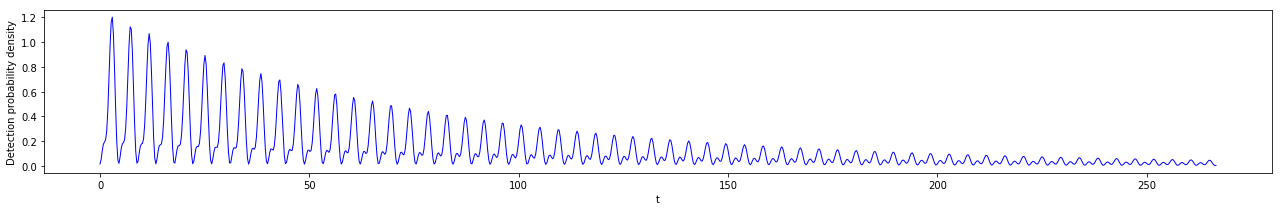

In [46]:
fig, ax = plt.subplots(figsize=(22, 3))
ax.set_xlabel('t')
ax.set_ylabel('Detection probability density')
ax.plot(times_extended, -np.gradient(norms_extended**2, times), c='b', linewidth=1)

## Page-Wootters

In [54]:
from scipy.linalg import dft, norm, expm

In [67]:
# Dimension of the system, or the spatial/"ordinary" Hilbert space
NS = 3
# Number of levels of the clock aka dimension of Time Hilbert space
NT = 32
# "Period"
DT = 2*np.pi/np.sqrt(2)

T = np.diag(np.arange(NT)) * 2*np.pi

In [68]:
F = dft(NT, scale='sqrtn').conj()
F_dagger = F.conj().T

In [69]:
Omega = F @ T @ F_dagger * 2*np.pi * NT / DT**2

In [70]:
J = np.kron(Omega, np.eye(3)) + np.kron(np.eye(NN), H_n)

In [90]:
eigenvalues, eigenvectors = np.linalg.eig(J)

In [91]:
eigenvectors = eigenvectors.T

In [114]:
# towards best-fidelity find
np.abs( ( eigenvectors[1][:3] / norm(eigenvectors[1][:3]) ).dot(psi_0_n) )**2

In [104]:
psi_0_n

array([0.70710678+0.j , 0.5       +0.5j, 0.        +0.j ])

In [108]:
norm

<function scipy.linalg.misc.norm>